In [1]:
"""
Written by Zain Kamal (zain.eris.kamal@rutgers.edu) on 06/19/2023.
https://github.com/Humboldt-Penguin/Mars-Magnetics-Research/tree/main/code


"""


import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
# from scipy.interpolate import RegularGridInterpolator

import zerisk.Utils as utils
import zerisk.DataDownloader as dd




class GRS:
    """
    Class allows you to get elemental concetrations at exact coordinates by linearly interpolating between the four nearest points. Both exact concentration and volatile-adusted (normalized to an H20 and Si free basis) are available.
    
    See README in downloaded folder to find more information on the data itself.
    """
    


    ############################################################################################################################################
    """ constant class variables """

    nanval: float = -1e10
    # Value given to pixels where data is not defined (i.e. "NOT_APPLICABLE_CONSTANT"). In the data, this is 9999.999 (see lbl file).

    def getNanVal(self) -> float:
        '''
        Return value used for coordinates where GRS doesn't provide data.
        '''
        return self.nanval











    ############################################################################################################################################
    """ instance class variables """
    # (if you're catching an AttributeError relating to one of these variables, it likely hasn't been assigned yet with something like `self.var=val``)



    path__pickledDataHome: str
    # Path from root to the directory within which the data folder either (1) already exists, or (2) will be downloaded.
    # e.g. '...\src\data\2_interim\pickled\'


    meta_dat: dict
    '''
    `meta_dat` is formatted as `meta_dat[element_name][quantity]`, where
        - `element_name` is from ['cl','fe','h2o','k','kvsth','si','th']
        - `quantity` is from:
            - 'concentration' = Concentration of the element. 
            - 'sigma' = The error associated with the concentration measurement. 
            - 'sigma_cfs' = The error associated with the concentration measurement. This error includes the errors associated with the correction factors applied to the concentration data if applicable. 

    Calling `meta_dat` as such gives a `scipy.interpolate._rgi.RegularGridInterpolator` object, which is a function that takes some [clon,lat] list and returns the linear interpolation of the original dataset to that coordinate.
    '''







    ############################################################################################################################################
    """ functions: initialize/load """
    
    
    
    def __init__(self) -> None:
        """
        Initialize empty GRS object (no data yet).
        """
        return
    
    
    

    
    
    def loadData(self, path__pickledDataHome: str = utils.getPath('current')) -> None:
        """
        DESCRIPTION:
        ------------
            Load crustal thickness data into `meta_dat` (dict). 

            `meta_dat` is formatted as `meta_dat[element_name][quantity]`, where
                - `element_name` is from ['cl','fe','h2o','k','kvsth','si','th']
                - `quantity` is from:
                    - 'concentration' = Concentration of the element. 
                    - 'sigma' = The error associated with the concentration measurement. 
                    - 'sigma_cfs' = The error associated with the concentration measurement. This error includes the errors associated with the correction factors applied to the concentration data if applicable. 

            Calling `meta_dat[element_name][quantity]` as such gives a `scipy.interpolate._rgi.RegularGridInterpolator` object, which is a function that takes some [clon,lat] list and returns the linear interpolation of the original dataset to that coordinate.


            NOTE: This version of `GRS.py` loads a pickled version of `meta_dat`. See '\src\data\2_interim\pickled' for more information. 

        """

        self.path__pickledDataHome = path__pickledDataHome

        path_datafile = utils.getPath(self.path__pickledDataHome, 'GRS', 'GRS.pkl')
        
        with open(path_datafile, "rb") as file:
            self.meta_dat = pickle.load(file)







    ############################################################################################################################################
    """ functions: accessing """



    def getConcentration(self, lon: float, lat: float, element_name: str, normalized: bool = True) -> float:

        if not normalized:
            clon = utils.lon2clon(lon)
            return self.meta_dat[element_name]['concentration']([clon,lat])[0]
        else:
            volatiles = ["cl", "h2o", "si"]
            if element_name in volatiles:
                raise Exception('Cannot normalize a volatile to a volatile-free basis.')

            raw = self.getConcentration(lon, lat, element_name, normalized=False)

            sum_volatile_concentration = 0

            for volatile in volatiles:
                volatile_concentration = self.getConcentration(lon, lat, volatile, normalized=False)
                if volatile_concentration < 0:
                    return self.getNanVal()
                sum_volatile_concentration += volatile_concentration

            return raw/(1-sum_volatile_concentration)


            
    def getSigma(self, lon: float, lat: float, element_name: str) -> float:
        clon = utils.lon2clon(lon)
        return self.meta_dat[element_name]['sigma']([clon,lat])[0]
            

    
    def getSigmaCFS(self, lon: float, lat: float, element_name: str) -> float:
        clon = utils.lon2clon(lon)
        return self.meta_dat[element_name]['sigma_cfs']([clon,lat])[0]
    






    ############################################################################################################################################
    """ functions: plotting """




    def visualize(self, element_name: str, resolution: float, normalized: bool = True) -> None:
        dat = []

        lon_left = -180
        lon_right = 180
        lat_bottom = -75
        lat_top = 75


        for lat in np.arange(lat_bottom, lat_top, resolution):
            newline = []
            for lon in np.arange(lon_left, lon_right, resolution):

                '''modify this line to change value being plotted'''
                val = self.getConcentration(lon, lat, element_name, normalized)
                # val = grs.getSigma(lon, lat, element_name)

                newline.append(val)
            dat.append(newline)


        '''apply mask'''
        dat = np.asarray(dat)
        dat = np.ma.masked_where((dat <= 0), dat)



        '''primary plot'''
        fig = plt.figure(figsize=(10,7))
        ax = plt.axes()
        im = ax.imshow(dat[::-1], cmap='jet', extent=[lon_left, lon_right, lat_bottom, lat_top])

        '''titles'''
        title = f'GRS {element_name.capitalize()} Abundance Map'
        if normalized:
            title += " (Normalized to a Volatile-Free Basis)"
        ax.set_title(title)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

        '''axis formatter'''
        ax.xaxis.set_major_formatter('{x}$\degree$')
        ax.yaxis.set_major_formatter('{x}$\degree$')


        '''x ticks'''
        '''Option 1: Set the spacing between x ticks'''
        # x_spacing = 60
        # ax.set_xticks(np.linspace(lon_left, lon_right, int((lon_right-lon_left)/x_spacing)+1))
        '''Option 2: Set the number of x ticks'''
        x_ticks = 7
        ax.set_xticks(np.linspace(lon_left, lon_right, x_ticks))

        '''y ticks'''
        '''Option 1: Set the spacing between y ticks'''
        # y_spacing = 25
        # ax.set_yticks(np.linspace(lat_bottom, lat_top, int((lat_top-lat_bottom)/y_spacing)+1))
        '''Option 2: Set the number of y ticks'''
        y_ticks = 7
        ax.set_yticks(np.linspace(lat_bottom, lat_top, y_ticks))

        '''color bar'''
        cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label(f'Concentration [out of 1]', y=0.5)

        plt.show()

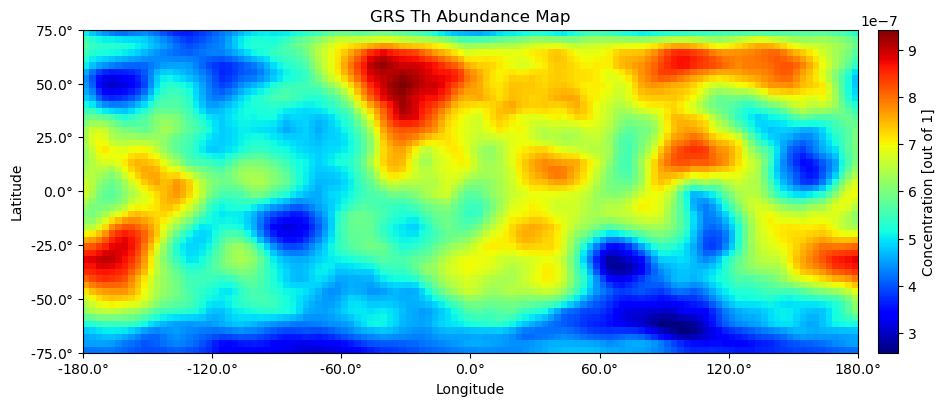

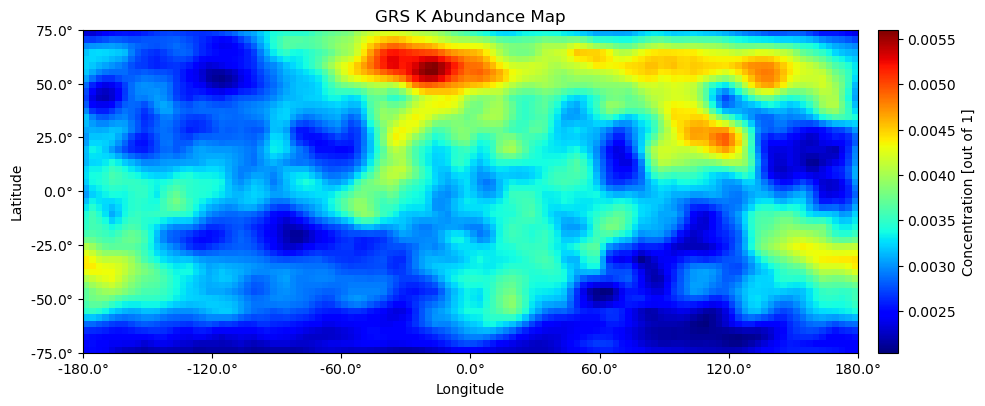

In [2]:
grs = GRS()
grs.loadData(path__pickledDataHome=r'C:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\2_interim\pickled')

grs.visualize('th', resolution=3, normalized=False)
grs.visualize('k', resolution=3, normalized=False)